# Figure 2: Plot human phenotype (schizophrenia and neurotypical) curves atop informative prior

## Manuscript Information
 
"Contrast Response Function Estimation with Nonparametric Bayesian Active Learning"
Dom CP Marticorena, Quinn Wai Wong, Jake Browning, Ken Wilbur, Samyukta Jayakumar, Pinakin Davey, Aaron R. Seitz, Jacob R. Gardner, Dennis L. Barbour
_Journal of Vision_
https://www.medrxiv.org/content/10.1101/2023.05.11.23289869v2

## Lab and Institution Information

NeuroMedical Informatics Lab  
Washington University in St. Louis

## Figure Description

Display Contrast Sensitivity Function (CSF) curves estimated from an intermediate stage of a contrast training study for individual diagnosed with schizophrenia  (left) and individuals with no known neurological disorder (right), as used in Experiment 2 of the current study. Superimpose these curves on a Contrast Response Function (CRF) defined by averaging Gaussian Processes (GPs) trained with simulated data to recapitulate each of the four canonical CSFs.

## References

Yaghoubi, K. C., Jayakumar, S., Ahmed, A. O., Butler, P. D., Silverstein, S., Thompson, J. L., & Seitz, A. R. (2022). Characterization of training profiles between individuals with schizophrenia and healthy individuals on Contrast Detection and Contour Integration tasks. Journal of Vision, 22(14), 3728–3728. https://jov.arvojournals.org/article.aspx?articleid=2784727&resultClick=1


In [1]:
# Import libraries

import sys
import torch as pt
import gpytorch as gp
from utility.utils import *

import numpy as np

import json
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Check versions of imported libraries

print("python version -->>", sys.version)
print("pytorch version -->>", pt.__version__)
print("gpytorch version -->>", gp.__version__)

python version -->> 3.10.9 (main, Mar  8 2023, 04:44:36) [Clang 14.0.6 ]
pytorch version -->> 1.13.1
gpytorch version -->> 1.8.1


This code was written for

- python version 3.10.9
- pytorch version 1.13.1
- gpytorch version 1.8.1

In [3]:
# Run-time flags

verb_mode = True           # print verbose analyses?
scrn_mode = True           # plot on screen?
save_mode = True           # save plots in indicated directory?

plot_canon   = True        # plot canonical CSF spline-interpolated curves?
plot_prior   = True        # plot GP posterior mean as prior?
plot_thresh  = False       # plot 50% threshold curve of prior?

In [4]:
# Constant declarations

# Fix random seed
generative_random_seed = 1

# evaluation grid bounds in raw linear units
raw_freq_min = 0.5       # cycles per degree
raw_freq_max = 32        # cycles per degree
raw_contrast_min = 1e-3  # contrast
raw_contrast_max = 1     # contrast

# marginal log resolutions of evaulation grid
x_resolution = 15  # 15 spatial frequencies per octave
y_resolution = 30  # 30 contrast units per decade

# for computing the proper prior threshold curve
psi_gamma  = 0.04  # guess rate is 4%
psi_lambda = 0.04  # lapse rate is 4%

# GP hyperparameters?
scale_factor = 0.4
gaussian_lengthscale = None
min_lengthscale = 0.15

# other
data_dir = 'data/raw_data/'
data_file_name = 'csf_curves_exp2.json'
data_file_path = f'{data_dir}{data_file_name}'

SCHIZOPHRENIA = 'Schizophrenia'
NEUROTYPICAL = 'Neurotypical'
SCHIZOPHRENIA_short = 'SZ'
NEUROTYPICAL_short = 'NT'

csf_curves_exp2 = load_json_from_file(data_file_path)

participants_by_phenotype = [
    (SCHIZOPHRENIA, csf_curves_exp2['schizophrenia_participants']),
    (NEUROTYPICAL, csf_curves_exp2['neurotypical_participants']),
]

smooth_curves = False

prior_model_names = ['textbook'] # TODO: refactor in CSF-23

prior_raw_freq_min = 0.5
prior_raw_freq_max = 64
prior_raw_contrast_min = 1e-3
prior_raw_contrast_max = 1

cax_location_params = [0.84, 0.1, 0.02, 0.8] # [left, bottom, width, height]

subplots_adjust_params = {
    'bottom':0.1, 
    'top':0.9, 
    'left':0.1, 
    'right':0.8, 
    'wspace':0.08, 
    'hspace':0.3
}

prior_inducing_point_raw_freq = 64
prior_inducing_point_raw_contrast = 1e-4
prior_inducing_point_label = 0

cb_tick_fontsize = 10
cb_label_fontsize = 12

legend_loc = 'upper right'

axis_tick_params = {
    'axis':'both', 
    'which':'major', 
    'direction':'out'
}

In [5]:
# Standard plotting parameters

fig_width = 11.25  # inches
fig_height = 4.5  # inches

dpi_val = 600

plt.rcParams['font.family'] = 'Arial'

legend_font_size = 8
legend_font_weight = 'roman'
tick_font_size = 10
tick_font_weight = 'roman'
label_font_size = 12
label_font_weight = 'roman'
title_font_size = 14
title_font_weight = 'roman'
suptitle_font_size = 16
suptitle_font_weight = 'roman'

hist_color = 'lightgrey'  # fill color of histogram bars
colors = sns.color_palette('colorblind', n_colors=12)  # colorblind friendly palette
col_1 = 0
col_2 = 1
col_3 = 2
col_4 = 4
mean_color = 'c'  # cyan
point_size = 20

x_tick_labels = [0.5, 2, 8, 32]
x_tick_values = logFreq().forward(np.array(x_tick_labels))
y_tick_labels = [1, 0.1, 0.01, 0.001]
y_tick_values = logContrast().forward(np.array(y_tick_labels))
cb_tick_labels = [0, 0.25, 0.5, 0.75, 1]
cb_tick_values = cb_tick_labels

cb_pad = 0.05  # move colorbar xx units horizontally
cb_label_pad = -58  # move colorbar label xx units horizontally

num_spline_vals = 100  # number of interpolated points in spline curves

color_map = 'gist_gray'

p_title = 'Canonical Phenotypes & Informative Prior'
x_label = 'Spatial Frequency (cyc/deg)'
y_label = 'Contrast'
cb_label = 'Detection Probability'

p_title = 'Real Human Contrast Sensitivity Phenotypes'
x_label = 'Spatial Frequency (cyc/deg)'
y_label = 'Contrast'
cb_label = 'Detection Probability'

save_dir = './analysis/figure_02/'
file_stem = 'Figure02_NL+SZ&Prior'

## Perform analysis

In [6]:
# Convert raw bounds to log units
x_min = logFreq().forward(raw_freq_min)
x_max = logFreq().forward(raw_freq_max)
y_min = logContrast().forward(raw_contrast_max)  # Max and min get flipped when inverting
y_max = logContrast().forward(raw_contrast_min)

################
# CREATE PRIOR #
################

# Create evaluation grid with resolution parameters
grid, xx, yy, xs, ys = create_evaluation_grid_resolution(x_min, x_max, y_min, y_max, x_resolution, y_resolution)

param_dicts = []  # List to hold parameter dictionaries for each prior model

# Get parameters needed for informative prior
for prior_model_name in prior_model_names:
    param_dict = {
        'state_dict_path': f'data/priors/prior_mean_model_state_{prior_model_name}.pth',
        'Xt_path': f'data/priors/prior_mean_model_Xt_{prior_model_name}.pth',
        'scale_factor': scale_factor,
        'gaussian_lengthscale': gaussian_lengthscale,
        'min_lengthscale': min_lengthscale,
        'psi_gamma': psi_gamma,
        'psi_lambda': psi_lambda,
    }
    param_dicts.append(param_dict)

# Function to scale data for Gaussian Process training
def f(d):
    return scale_data_within_range(d, (0, 1),\
    logFreq().forward(prior_raw_freq_min), logFreq().forward(prior_raw_freq_max),\
    logContrast().forward(prior_raw_contrast_max), logContrast().forward(prior_raw_contrast_min))

# Generate a single point to initialize the Gaussian Process model for plotting
x1 = logFreq().forward(np.array([prior_inducing_point_raw_freq]))
x2 = logContrast().forward(np.array([prior_inducing_point_raw_contrast]))
X = np.vstack((x1, x2)).T
y = np.array([prior_inducing_point_label])
Xt = transform_dataset(X, phi=f)
yt = torch.from_numpy(y).float()

# Setup mean module, model, and likelihood for Gaussian Process
mean_module = get_mean_module('prior_gp_mean', param_dicts)
model = GPClassificationModel(Xt, mean_module=mean_module, min_lengthscale=min_lengthscale)
likelihood = CustomBernoulliLikelihood(psi_gamma, psi_lambda)

# Evaluate the posterior mean for the Gaussian Process
grid_transformed = transform_dataset(grid, phi=f)
Z = evaluate_posterior_mean(model, likelihood, grid_transformed)
zz = Z.reshape(xx.shape)

/Users/dbarbour/opt/anaconda3/envs/csf-env-manu1/lib/python3.10/site-packages/gpytorch/means/constant_mean.py:20: OldVersionWarning: You have loaded a GP model with a ConstantMean  from a previous version of GPyTorch. The mean module parameter `constant` has been renamed to `raw_constant`. Additionally, the shape of `raw_constant` is now *batch_shape, whereas the shape of `constant` was *batch_shape x 1. We have updated the name/shape of the parameter in your state dict, but we recommend that you re-save your model.
  warnings.warn(
/Users/dbarbour/opt/anaconda3/envs/csf-env-manu1/lib/python3.10/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_tri

## Plot figure

<Figure size 640x480 with 0 Axes>

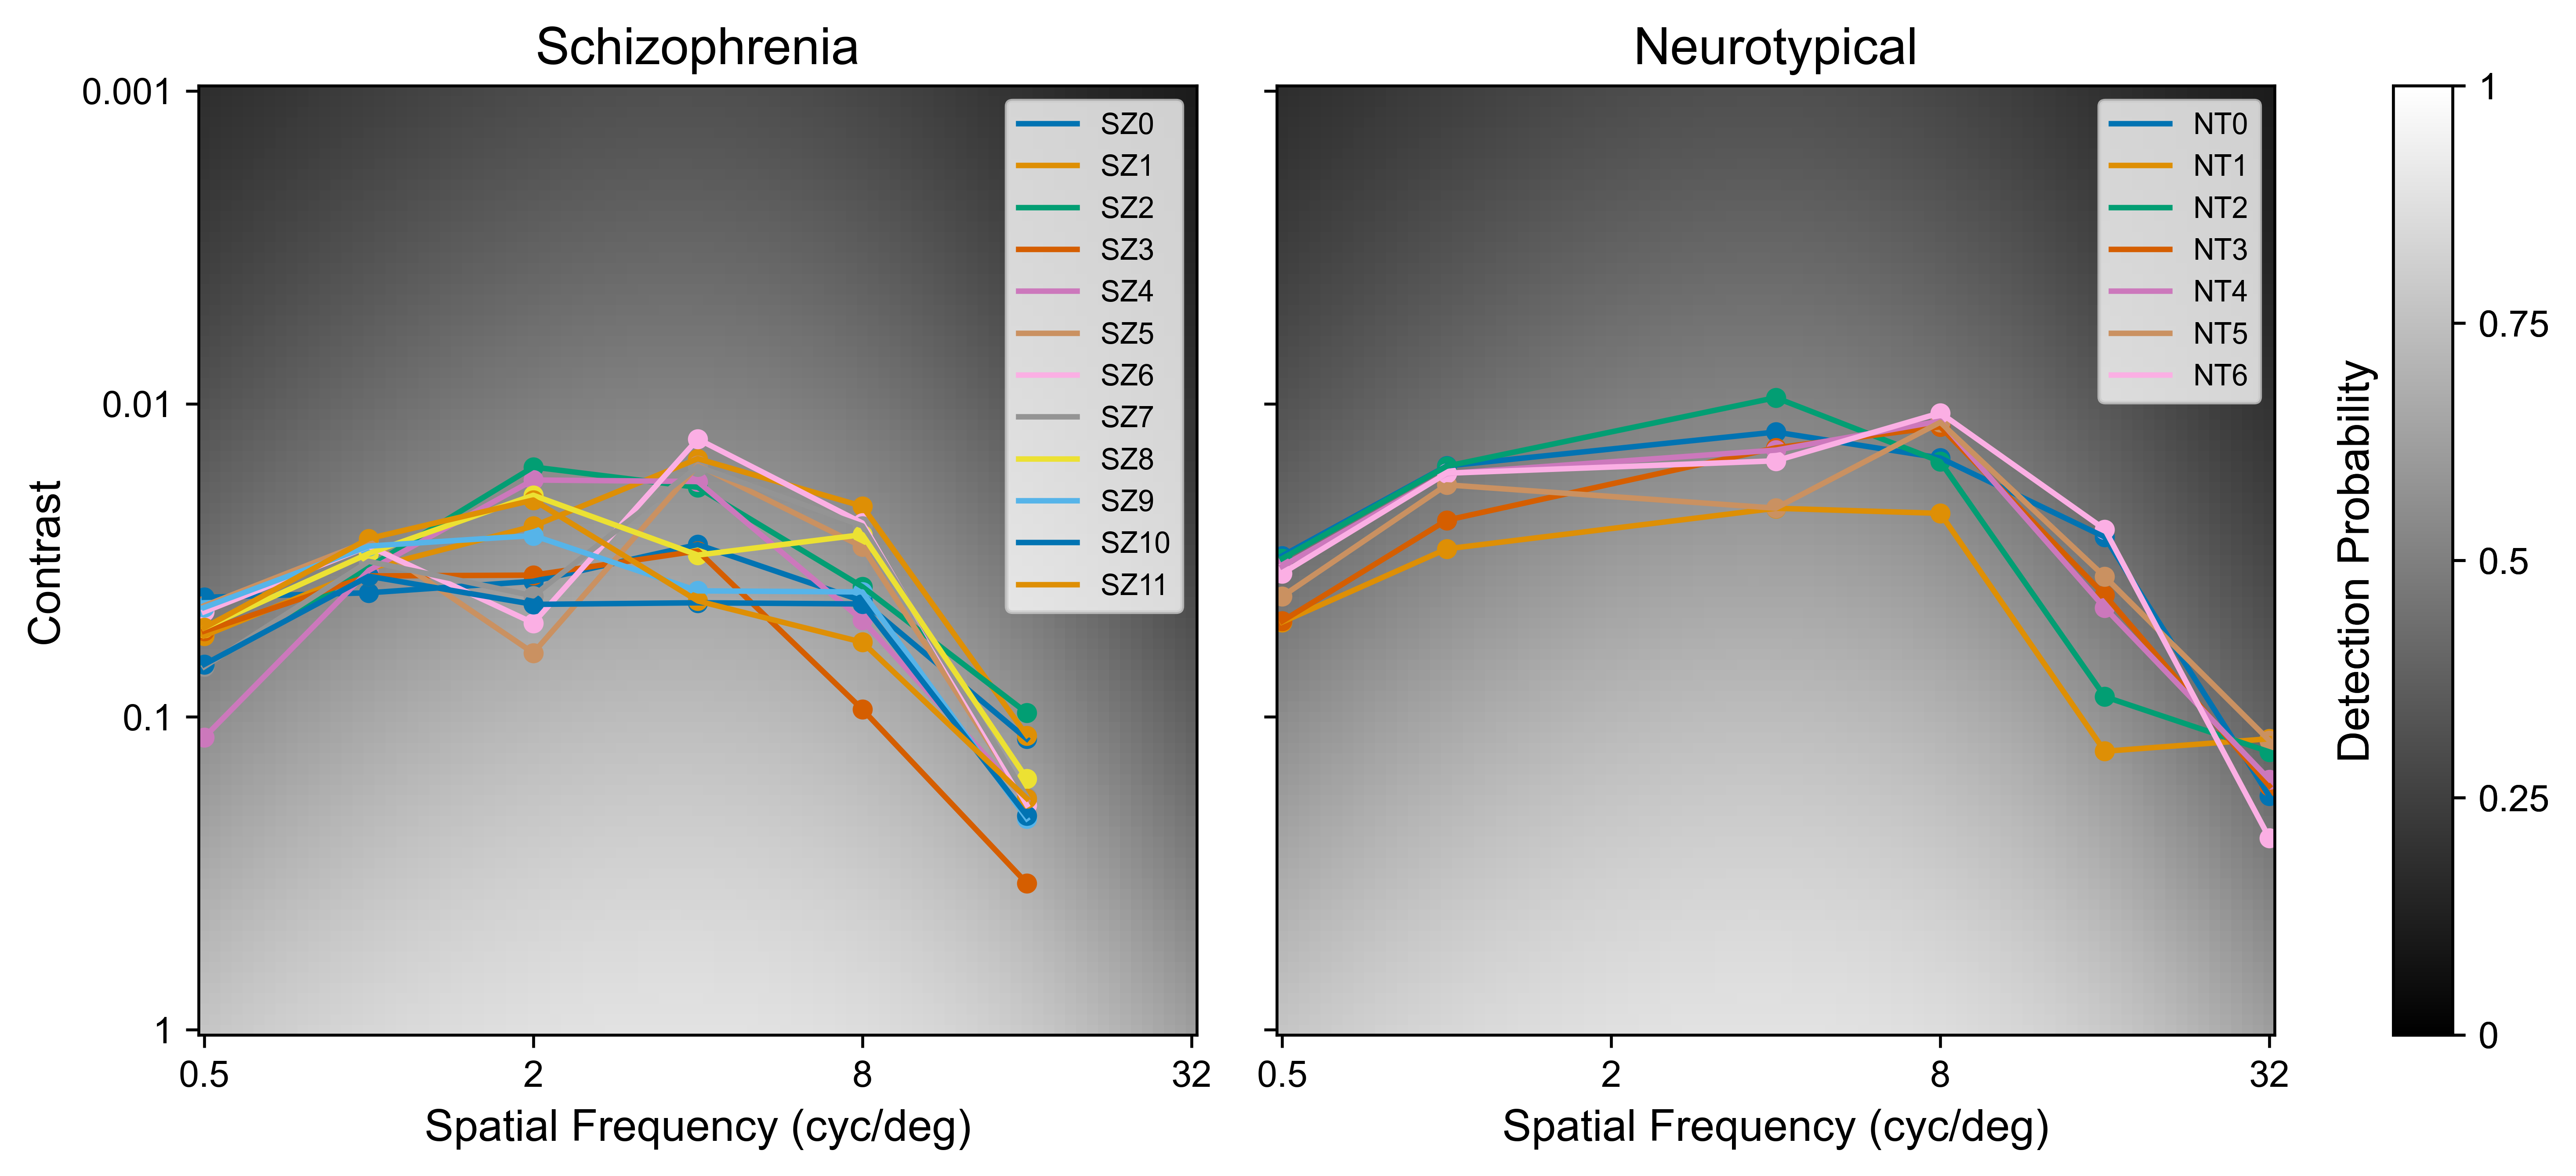

In [7]:
# Plot the real CSF curves on top of a GP posterior mean as CRF

%matplotlib inline
plt.tight_layout()

# Set figure size
fig, axs = plt.subplots(1, 2, figsize=(fig_width, fig_height), dpi=dpi_val)

# Compute padding values
x_padding = (x_max - x_min) / (2 * (xs - 1))
y_padding = (y_max - y_min) / (2 * (ys - 1))

for phenotype, participants in participants_by_phenotype:
    
    if phenotype == SCHIZOPHRENIA:
        label = SCHIZOPHRENIA_short
        ax = axs[0]
    elif phenotype == NEUROTYPICAL:
        ax = axs[1]
        label = NEUROTYPICAL_short

    # Plot contour
    if plot_prior:
        mesh = ax.pcolormesh(xx, yy, zz, cmap=color_map, vmin=0, vmax=1)
        cax = fig.add_axes(cax_location_params)
        cbar = fig.colorbar(mesh, cax=cax, ticks=cb_tick_values, format='%g')
        cbar.set_label(cb_label, labelpad=cb_label_pad, size=cb_label_fontsize)
        cbar.ax.tick_params(labelsize=cb_tick_fontsize)

    # Plot threshold
    if plot_thresh:
        level = (1 - psi_lambda + psi_gamma) / 2
        ax.contour(xx, yy, zz, levels=[level], colors=mean_color)

    # Plot by participant
    if plot_canon:
        for i, participant in enumerate(participants):
            participant = np.array(participant)
            participant[:, 0] = (np.log2(10) * participant[:, 0]) - np.log2(.125)
            
            if smooth_curves:
                left, right, _, _ = get_data_bounds(participant)
                x = np.linspace(left, right, num_spline_vals)
                cs = create_cubic_spline(participant)
                y = cs(x)
                ax.plot(x, y, color=colors[i], label=f"{label}{i}")
            else:
                x = participant[:, 0]
                y = participant[:, 1]
                ax.plot(x, y, color=colors[i], label=f"{label}{i}")
                ax.scatter(x, y, color=colors[i], s=point_size)
                
        ax.legend(loc=legend_loc, fontsize=legend_font_size)

    # Settings
    ax.set_title(phenotype, fontsize=title_font_size)
    ax.tick_params(**axis_tick_params, labelsize=tick_font_size)
    ax.set_xlabel(x_label, fontsize=label_font_size)
    ax.set_ylabel(y_label, fontsize=label_font_size)
    ax.set_xlim(x_min - x_padding, x_max + x_padding)
    ax.set_ylim(y_min - y_padding, y_max + y_padding)
    ax.label_outer()

# Adjust and create colorbar
fig.subplots_adjust(**subplots_adjust_params)

plt.setp(axs, xticks=x_tick_values, xticklabels=x_tick_labels, yticks=y_tick_values, yticklabels=y_tick_labels)

if save_mode:
    ensure_directory_exists(save_dir)
    plt.savefig(f'{save_dir}{file_stem}.png', bbox_inches='tight', dpi=dpi_val)
    plt.savefig(f'{save_dir}{file_stem}.pdf', bbox_inches='tight', dpi=dpi_val)

if scrn_mode:
    plt.show()
else:
    plt.clf()